<a href="https://colab.research.google.com/github/S-VATS31/Deep_Learning_Models/blob/main/Vats_Transformer_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [175]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# **Sinusoidal Positional Encodings**

In [176]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, T, d_model, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        """Initialize sinusoidal positional encoding layer.

        Generates fixed positional encodings using sine and cosine functions to provide
        position information for sequences in transformer models. Encodings are computed
        for a fixed sequence length and stored as a non-learnable buffer meaning it is
        not passed through backpropagation.

        Args:
            T (int): Maximum sequence length (number of tokens).
            d_model (int): Dimensionality of the model's input/output representations.
                Must be even for sine/cosine splitting.

        Attributes:
            PE (torch.Tensor): Positional encoding tensor of shape (T, d_model),
                registered as a buffer (non-learnable).
        """
        self.dropout = torch.nn.Dropout(p=dropout)

        # Create position indices
        position = torch.arange(0, T).unsqueeze(1).float() # [T, 1]

        # Compute denominator of Sinusoidal Positional encoding algorithm
        divisor = torch.exp(torch.arange(0, d_model, 2).float() * - (math.log(10000.0) / d_model)) # [d_model//2]

        # Create Sine and Cosine encodings
        PE = torch.zeros(T, d_model) # [T, d_model]

        PE[:, 0::2] = torch.sin(position * divisor) # Even indices --> Sine (2i)
        PE[:, 1::2] = torch.cos(position * divisor) # Odd indices --> Cosine (2i+1)

        # Register encodings as a buffer rather being a learned/updated parameter
        self.register_buffer('PE', PE)

    def forward(self, x):
        """Apply sinusoidal positional encodings to the input tensor.

        Adds precomputed positional encodings to the input tensor to incorporate
        positional information.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Input tensor with positional encodings added, using element-wise addition.
        """
        # Add positional encodings
        x = x + self.PE[:x.size(1), :]

        # Apply dropout to avoid overfitting
        x = self.dropout(x)
        return x


# **Graph Sinusoidal Positional Encodings**

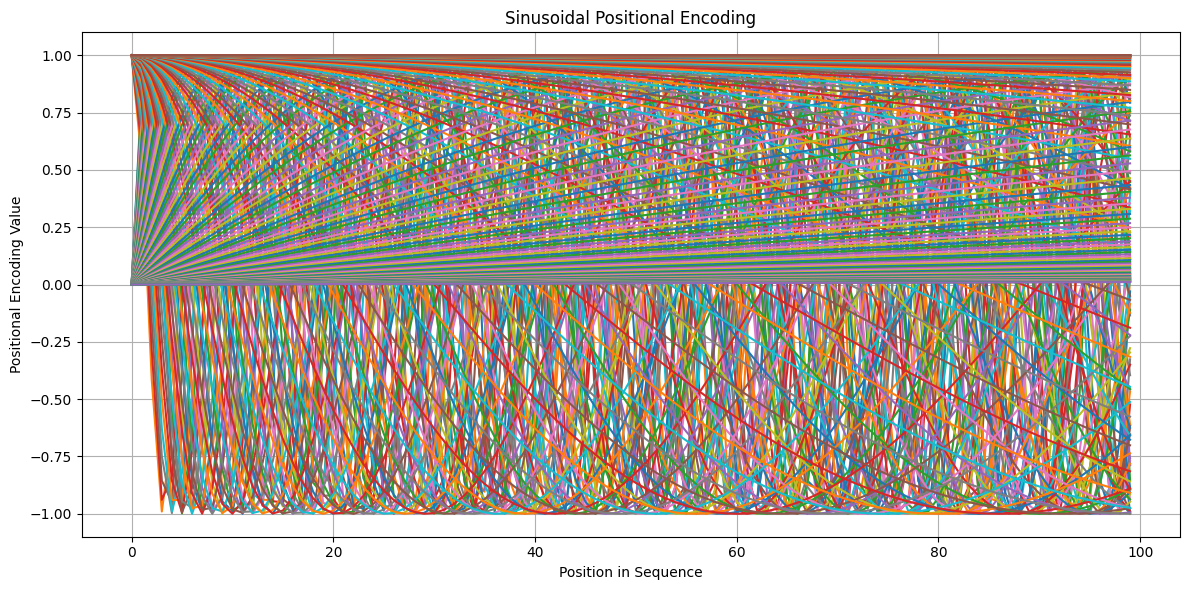

In [177]:
def graph_PE(T, d_model):
    """Generate sinusoidal positional encodings for visualization.

    Computes positional encodings using sine and cosine functions for a given sequence
    length and model dimensionality. Returns a tensor meant for plotting to visualize
    positional encoding patterns.

    Args:
        T (int): Sequence length (number of tokens).
        d_model (int): Dimensionality of the model's representations. Must be even
            for sine/cosine splitting.

    Returns:
        torch.Tensor: Positional encoding tensor of shape (T, d_model), with sine
            values at even indices and cosine values at odd indices.
    """
    # Create position indices
    position = torch.arange(0, T).unsqueeze(1).float() # [T, 1]

    # Compute denominator of Sinusoidal Positional encoding algorithm
    divisor = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)) # [d_model//2]

    # Create Sine and Cosine encodings
    PE = torch.zeros(T, d_model) # [T, d_model]
    PE[:, 0::2] = torch.sin(position * divisor) # Even indices --> Sine (2i)
    PE[:, 1::2] = torch.cos(position * divisor) # Odd indices --> Cosine (2i+1)

    return PE

# Parameters
T = 100
d_model = 256

# Call graphing function
PE = graph_PE(T, d_model)

# Plot each dimension
plt.figure(figsize=(12, 6))
for i in range(d_model):
    plt.plot(torch.arange(T), PE[:, i], label=f"dim {i}")

plt.title("Sinusoidal Positional Encoding")
plt.xlabel("Position in Sequence")
plt.ylabel("Positional Encoding Value")
plt.grid(True)
plt.tight_layout()
plt.show()


# **Layer Normalization**

In [178]:
class LayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, dtype=torch.float32):
        """Initialize Layer Normalization module.

        Layer Normalization normalizes the input tensor over the last dimension, stabilizing training by
        reducing internal covariate shift. It applies learnable scaling (gamma) and shifting (beta) parameters
        to the normalized tensor.

        Args:
            normalized_shape (torch.Tensor): Shape of the input tensor's normalized dimension(s).
                For example, if the input is (batch, seq_len, features), this would be `features` or
                a tuple of the last dimensions.
            eps (float, optional): Small constant added to the variance to prevent division by zero.
                Defaults to 1e-6.
            dtype (torch.dtype, optional): Data type for the learnable parameters. Defaults to torch.float32.

        Attributes:
            gamma (torch.nn.Parameter): Learnable scaling factor, initialized to ones.
            beta (torch.nn.Parameter): Learnable shift factor, initialized to zeros.
            eps (float): Small constant for numerical stability.
        """
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.gamma = torch.nn.Parameter(torch.ones(normalized_shape, dtype=dtype)) # Scaling factor
        self.beta = torch.nn.Parameter(torch.zeros(normalized_shape, dtype=dtype)) # Shifiting factor

    def forward(self, x):
        """Perform Layer Normalization on the input tensor.

        Normalizes the input tensor over the last dimension by subtracting the mean and dividing by the
        standard deviation, then applies learnable scaling (gamma) and shifting (beta).

        Args:
            x (torch.Tensor): Input tensor of shape (..., normalized_shape).

        Returns:
            x (torch.Tensor): Normalized and transformed tensor of the same shape as the input,
                computed as `gamma * normalized_x + beta`.
        """
        mean = x.mean(dim=-1, keepdim=True) # Compute mean over the last dimension
        var = x.var(dim=-1, unbiased=False, keepdim=True) # Compute variance over the last dimension
        normalized_x = (x - mean) / torch.sqrt(var + self.eps) # Normalize the input
        x = self.gamma * normalized_x + self.beta # Apply scaling and shifting
        return x

# **Multi Headed Attention**

In [182]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, T, B, d_model, num_heads, dropout=0.1):
        """Initialize Multi-Head Attention module.

        Implements multi-head self-attention mechanism for transformer models, allowing the model
        to focus on different parts of the input sequence simultaneously. Includes positional
        encoding, layer normalization, and dropout for regularization.

        Args:
            T (int): Maximum sequence length (number of tokens).
            B (int): Batch size.
            d_model (int): Dimensionality of the model's input/output representations.
                Must be divisible by num_heads.
            num_heads (int): Number of attention heads.
            dropout (float, optional): Dropout probability for attention weights and output.
                Defaults to 0.1.

        Attributes:
            d_k (int): Dimensionality of each attention head (d_model // num_heads).
            W_Q (torch.nn.Linear): Linear projection for queries.
            W_K (torch.nn.Linear): Linear projection for keys.
            W_V (torch.nn.Linear): Linear projection for values.
            W_O (torch.nn.Linear): Linear projection for output.
            positional_encoding (PositionalEncoding): Positional encoding layer.
            dropout (torch.nn.Dropout): Dropout layer for regularization.
            layer_norm (LayerNorm): Layer normalization module.
        """
        super(MultiHeadAttention, self).__init__()
        self.T = T
        self.B = B
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Weight Matrices
        self.W_Q = torch.nn.Linear(d_model, d_model)
        self.W_K = torch.nn.Linear(d_model, d_model)
        self.W_V = torch.nn.Linear(d_model, d_model)
        self.W_O = torch.nn.Linear(d_model, d_model)

        self.positional_encoding = PositionalEncoding(T, d_model) # Assigns each token to exact index
        self.dropout = torch.nn.Dropout(p=dropout) # Dropout to prevent overfitting
        self.layer_norm = LayerNorm(d_model) # Normalize and transform input tensor x

    def forward(self, x, padding=None, causal=True):
        """Apply multi-head attention to the input tensor.

        Computes scaled dot-product attention for multiple heads, incorporating positional
        encodings, layer normalization, and optional padding masks. Returns the attention
        output and attention weights. Applies autoregressive masking to prevent the transformer
        from looking at future tokens.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            padding (torch.Tensor, optional): Padding mask of shape (batch_size, seq_len).
                Zeros indicate padded positions; ones indicate valid positions.
                Defaults to None.

        Returns:
            tuple:
                - torch.Tensor: Attention output of shape (batch_size, seq_len, d_model).
                - torch.Tensor: Attention weights of shape (batch_size, num_heads, seq_len, seq_len).
        """
        residual = x # Residual connection
        x = self.layer_norm(x) # Apply LayerNorm

        # Apply Positional Encoding
        x = self.positional_encoding(x)

        # Linear projections
        Q = self.W_Q(x) # Query: [B, T, d_model]
        K = self.W_K(x) # Key:   [B, T, d_model]
        V = self.W_V(x) # Value: [B, T, d_model]

        # Reshape for multi-head attention
        Q = Q.view(self.B, self.T, self.num_heads, self.d_k).transpose(1, 2) # [B, num_heads, T, d_k]
        K = K.view(self.B, self.T, self.num_heads, self.d_k).transpose(1, 2) # [B, num_heads, T, d_k]
        V = V.view(self.B, self.T, self.num_heads, self.d_k).transpose(1, 2) # [B, num_heads, T, d_k]

        # Scaled Dot Product Attention
        assert Q.shape[-1] == K.shape[-1], f"Expected d_k {Q.shape[-1]}, but got {K.shape[-1]}" # Ensure matrix multiplication is compatible
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) # [B, num_heads, T, T]

        # Autoregressive Masking
        if causal:
            autoregressive_mask = torch.tril(torch.ones(T, T)) # [T, T]
            autoregressive_mask = autoregressive_mask.unsqueeze(0).unsqueeze(0) # [1, 1, T, T]
            autoregressive_mask = autoregressive_mask.expand(B, num_heads, T, T) # [B, num_heads, T, T]

            # Apply autoregressive mask
            attention_scores = attention_scores.masked_fill(autoregressive_mask == 0, float('-inf'))

        # Apply padding mask if given
        if padding is not None:
            padding = padding.unsqueeze(1).unsqueeze(2) # [B, 1, 1, T]
            attention_scores = attention_scores.masked_fill(padding == 0, float('-inf')) # Mask padded positions

        # Probability Distribution
        attention_weights = F.softmax(attention_scores, dim=-1) # [B, num_heads, T, T]
        attention_weights = self.dropout(attention_weights)

        # Ensure matrix multiplication is compatible
        assert attention_weights.shape[-1] == V.shape[-2], f"Expected T {attention_weights.shape[-1]}, but got {V.shape[-2]}"
        attention_output = torch.matmul(attention_weights, V) # [B, num_heads, T, d_k]

        # Concatenate the attention heads and apply final projection
        attention_output = attention_output.transpose(1, 2).contiguous().view(self.B, self.T, self.d_model) # [B, T, d_model]
        attention_output = self.dropout(attention_output) # Apply Dropout
        attention_output = self.W_O(attention_output) # Final output projection

        # Apply residual connection
        final_output = attention_output + residual
        return final_output, attention_weights

T = 100 # Number of tokens
B = 64 # Batch size
d_model = 256 # Dimensionality of the model's input/output
num_heads = 8 # Number of attention heads

# Initialize Multi-Head Attention
MHA = MultiHeadAttention(T, B, d_model, num_heads)

# Random input tensor (B, T, d_model)
x = torch.randn(B, T, d_model)

# Optional padding mask
mask = torch.ones(B, T) # No padding

# Forward pass
output, attention_weights = MHA(x, mask)


# **Feedforward MLP**

In [180]:
class FeedForwardMLP(torch.nn.Module):
    def __init__(self, d_ffn, d_model, dropout=0.1):
        """Feed-Forward Neural Network (FFN) module for Transformer models.

    Implements a two-layer feed-forward neural network with GELU activation, used within
    Transformer architectures to process each token independently. Includes pre-layer
    normalization, dropout for regularization, and a residual connection to stabilize training.

    Args:
        d_ffn (int): Dimensionality of the hidden layer in the feed-forward network.
        d_model (int): Dimensionality of the model's input/output representations.
        dropout (float, optional): Dropout probability for the output of the second linear layer.
            Defaults to 0.1.

    Attributes:
        weight_matrix1 (torch.nn.Parameter): Weight matrix for the first linear layer, shape (d_model, d_ffn).
        bias1 (torch.nn.Parameter): Bias for the first linear layer, shape (d_ffn).
        weight_matrix2 (torch.nn.Parameter): Weight matrix for the second linear layer, shape (d_ffn, d_model).
        bias2 (torch.nn.Parameter): Bias for the second linear layer, shape (d_model).
        dropout (torch.nn.Dropout): Dropout layer for regularization.
        layer_norm (LayerNorm): Layer normalization module.
        """
        super(FeedForwardMLP, self).__init__()

        # Linear layer 1
        self.weight_matrix1 = torch.nn.Parameter(torch.randn(d_model, d_ffn) * math.sqrt(2.0 / d_model)) # [d_model, d_ffn]
        self.bias1 = torch.nn.Parameter(torch.zeros(d_ffn)) # [d_ffn]

        # Linear layer 2
        self.weight_matrix2 = torch.nn.Parameter(torch.randn(d_ffn, d_model) * math.sqrt(2.0 / d_ffn)) # [d_ffn, d_model]
        self.bias2 = torch.nn.Parameter(torch.zeros(d_model)) # [d_model]

        # Dropout & LayerNorm
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = LayerNorm(d_model)

    def GELU(self, x):
        # Approximate GELU activation
        x = torch.clamp(x, -10, 10) # Prevents numerical instability
        x = 0.5 * x * (1 + torch.tanh(math.sqrt(2/math.pi) * (x + 0.044715 * x ** 3)))
        return x

    def forward(self, x):
        """Apply the feed-forward neural network to the input tensor.

        Processes the input through two linear layers with GELU activation between them,
        incorporating pre-layer normalization, dropout, and a residual connection.
        The module transforms each token independently across the sequence.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, d_model).
        """
        # Ensure matrix multiplication is compatible
        assert x.shape[-1] == self.weight_matrix1.shape[0], f"Expected d_model {self.weight_matrix1.shape[0]}, got {x.shape[-1]}"

        # Residual connection
        residual = x

        # PreNorm
        x = self.layer_norm(x)

        # First linear transformation
        x = self.GELU(torch.matmul(x, self.weight_matrix1) + self.bias1)

        # Second linear transformation
        x = torch.matmul(x, self.weight_matrix2) + self.bias2

        # Apply Dropout
        x = self.dropout(x)

        # Apply residual connection
        x = residual + x

        return x


# **Number of Parameters**

In [181]:
# Check total parameters
total_params = sum(p.numel() for p in MHA.parameters())
print(f"Total parameters: {total_params}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in MHA.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Total parameters: 263680
Trainable parameters: 263680
